In [9]:
# Adapted from :  https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [23]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [24]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [34]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
num_seqs =  10000
batch_size = 200
num_classes = 2
state_size = 1024
learning_rate = 0.25

In [35]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [36]:
tf.reset_default_graph()

"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

print(rnn_outputs.shape) # <n, t, h>
print(final_state.shape) # <n, h>
"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes]) # <n, t, o>

predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

(200, 10, 1024)
(200, 1024)


In [37]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        epoch_training_losses = np.zeros(num_epochs)
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            training_losses = []
            
            print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              optimizer],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                
                if step % 100 == 0 and step > 0:
                    print("Average loss at step", step,
                              ":", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
            
            epoch_training_losses[idx] = np.mean(np.array(training_losses))
            print("Epoch training loss :", epoch_training_losses[idx])

    return epoch_training_losses


EPOCH 0
Average loss at step 100 : 22.3305703998
Average loss at step 200 : 9.82172878265
Average loss at step 300 : 6.13336995363
Average loss at step 400 : 2.76864891529
Epoch training loss : 10.2635795128

EPOCH 1
Average loss at step 100 : 6.04686322927
Average loss at step 200 : 5.11781975985
Average loss at step 300 : 4.01131737471
Average loss at step 400 : 1.91892935276
Epoch training loss : 4.27373242915

EPOCH 2
Average loss at step 100 : 4.33756043196
Average loss at step 200 : 3.85316433668
Average loss at step 300 : 2.81386181712
Average loss at step 400 : 1.34786674857
Epoch training loss : 3.08811333358

EPOCH 3
Average loss at step 100 : 3.44485418797
Average loss at step 200 : 3.10069979668
Average loss at step 300 : 1.96051684856
Average loss at step 400 : 2.16096857548
Epoch training loss : 2.66675985217

EPOCH 4
Average loss at step 100 : 2.83920959473
Average loss at step 200 : 1.84951525688
Average loss at step 300 : 2.07423359513
Average loss at step 400 : 2.767


EPOCH 39
Average loss at step 100 : 0.889384043813
Average loss at step 200 : 0.886698371172
Average loss at step 300 : 0.898734672666
Average loss at step 400 : 0.877508904338
Epoch training loss : 0.888081497997

EPOCH 40
Average loss at step 100 : 0.889790956378
Average loss at step 200 : 0.866548358202
Average loss at step 300 : 0.871712152362
Average loss at step 400 : 0.879104768038
Epoch training loss : 0.876789058745

EPOCH 41
Average loss at step 100 : 0.875146500468
Average loss at step 200 : 0.878174923658
Average loss at step 300 : 0.854384824038
Average loss at step 400 : 0.862648019791
Epoch training loss : 0.867588566989

EPOCH 42
Average loss at step 100 : 0.857760199904
Average loss at step 200 : 0.868977528811
Average loss at step 300 : 0.86684692502
Average loss at step 400 : 0.85405307889
Epoch training loss : 0.861909433156

EPOCH 43
Average loss at step 100 : 0.851809332967
Average loss at step 200 : 0.852956593633
Average loss at step 300 : 0.86336466372
Average

Average loss at step 200 : 0.694354376197
Average loss at step 300 : 0.719778177738
Average loss at step 400 : 0.71781046927
Epoch training loss : 0.706074674726

EPOCH 78
Average loss at step 100 : 0.709820660949
Average loss at step 200 : 0.710062428713
Average loss at step 300 : 0.687449287176
Average loss at step 400 : 0.716001694798
Epoch training loss : 0.705833517909

EPOCH 79
Average loss at step 100 : 0.700529034138
Average loss at step 200 : 0.699285548925
Average loss at step 300 : 0.714241468906
Average loss at step 400 : 0.707386670113
Epoch training loss : 0.705360680521

EPOCH 80
Average loss at step 100 : 0.700776774883
Average loss at step 200 : 0.679536912441
Average loss at step 300 : 0.719317144156
Average loss at step 400 : 0.682032563686
Epoch training loss : 0.695415848792

EPOCH 81
Average loss at step 100 : 0.690099233985
Average loss at step 200 : 0.725041383505
Average loss at step 300 : 0.706257320046
Average loss at step 400 : 0.697268704772
Epoch training 

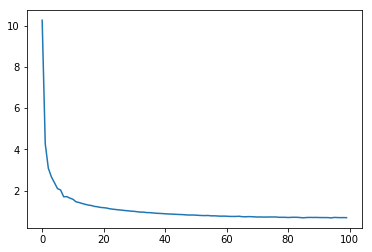

In [40]:
training_losses = train_network(100,num_steps, state_size)
plt.plot(training_losses)